# Trabalho Final - Deep Learning and Reinforcement Learning

### Integrantes:

###    1) Jurandir Ventura - RM336634
###    2) Marcelo Preto - RM336632
###    3) Fabio Rizzi - RM336656
###    4) Thiago Alexandre – RM336583

## Keras

## Exercício #5 - 1 PONTO
### Utilizando o dataset do Spotify (disponível no repositório da disciplina) construa um modelo sequencial ou funcional no Keras para fazer a classificação desse dataset.

## Dicas:
#### Tente calibrar a quantidade de camadas e neurônios a fim de atingir uma taxa de acerto semelhante a um SVM otimizado;
#### Tente utilizar dropout a fim de evitar eventual overfitting.

* Aplique os pré-processamentos necessários.
* Apresente a evolução do conjunto de treino e validação.
* Apresente a acurácia do conjunto de testes.
* Apresente a configuração (estrutura) da rede neural.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from matplotlib import pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model
random_state=42

In [2]:
# Carregando dataset
df=pd.read_csv("data/ex5-spotify.csv", index_col=0, delimiter=',', encoding='UTF-8')

In [3]:
# Amostra do dataset
df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


In [4]:
df.target.value_counts()

1    1020
0     997
Name: target, dtype: int64

### Coluna target desbalanceada

Utilizando estratégia de upsampling.

*Referência: https://elitedatascience.com/imbalanced-classes*

In [5]:
from sklearn.utils import resample

# Separando as features em maioria e minoria
df_maioria = df[df.target==1]
df_minoria = df[df.target==0]

# Fazendo upsampling para igualar a quantidade de valores target
df_minoria_aumentado = resample(df_minoria, replace=True, n_samples=df_maioria.shape[0], random_state=random_state)

# Juntando o dataset com os valores de features balanceados
df_balanceado = pd.concat([df_maioria, df_minoria_aumentado])

df_balanceado.target.value_counts()
df = df_balanceado

#### Coluna target balanceada

In [6]:
df.target.value_counts()

1    1020
0    1020
Name: target, dtype: int64

In [7]:
# Informações sobre as colunas do dataset
df.info();
print("\n* Não há valores nulos")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2040 entries, 0 to 1629
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      2040 non-null   float64
 1   danceability      2040 non-null   float64
 2   duration_ms       2040 non-null   int64  
 3   energy            2040 non-null   float64
 4   instrumentalness  2040 non-null   float64
 5   key               2040 non-null   int64  
 6   liveness          2040 non-null   float64
 7   loudness          2040 non-null   float64
 8   mode              2040 non-null   int64  
 9   speechiness       2040 non-null   float64
 10  tempo             2040 non-null   float64
 11  time_signature    2040 non-null   float64
 12  valence           2040 non-null   float64
 13  target            2040 non-null   int64  
 14  song_title        2040 non-null   object 
 15  artist            2040 non-null   object 
dtypes: float64(10), int64(4), object(2)
memory

In [8]:
print("Colunas do dataset:\n")
print(format(sorted(df.columns.to_list())))

Colunas do dataset:

['acousticness', 'artist', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'song_title', 'speechiness', 'target', 'tempo', 'time_signature', 'valence']


### Descrição das colunas:

- track: The Name of the track.

- artist: The Name of the Artist.

- uri: The resource identifier for the track.

- danceability: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. 

- energy: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. 

- key: The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C?/D?, 2 = D, and so on. If no key was detected, the value is -1.

- loudness: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db. 

- mode: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

- speechiness: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. 

- acousticness: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. The distribution of values for this feature look like this:

- instrumentalness: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. The distribution of values for this feature look like this:

- liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

- valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

- tempo: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. 

- duration_ms:  The duration of the track in milliseconds.

- time_signature: An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).

- chorus_hit: This the the author's best estimate of when the chorus would start for the track. Its the timestamp of the start of the third section of the track. This feature was extracted from the data received by the API call for Audio Analysis of that particular track.

- sections: The number of sections the particular track has. This feature was extracted from the data received by the API call for Audio Analysis of that particular track.

- **target: The target variable for the track. It can be either '0' or '1'. '1' implies that this song has featured in the weekly list (Issued by Billboards) of Hot-100 tracks in that decade at least once and is therefore a 'hit'. '0' Implies that the track is a 'flop'.**

*Fonte: https://www.kaggle.com/theoverman/the-spotify-hit-predictor-dataset*

In [9]:
# Removendo colunas categóricas
df.drop(['artist','song_title'], axis=1, inplace=True)

In [10]:
# Separando classes e target
X = df.loc[:, df.columns != 'target'].astype(float)
y = df.loc[:, df.columns == 'target'].astype(int)

In [11]:
from sklearn import preprocessing
X = preprocessing.scale(X)

In [12]:
# One-hot encoding da coluna de classes
y=pd.get_dummies(y,drop_first=True)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)

In [14]:
# modelo sequencial
print(X.shape[1], "entradas")
print(y.shape[1] + 1, "saídas\n")

model = Sequential()

model.add(Dense(64, input_dim=X.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(64, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax')) # 2 opções
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

13 entradas
2 saídas

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4096      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None

In [15]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=150)
mc = ModelCheckpoint(filepath='modelo-5.hdf5', verbose=1, save_best_only=True, monitor='val_accuracy')
try:
    hist = model.fit(X_train, y_train, batch_size=32, epochs=600, callbacks=[es, mc], verbose=1, shuffle=True, validation_split=0.1)
except KeyboardInterrupt:
    hist = model.history

41/52 [======================>.......] - ETA: 0s - loss: 0.3563 - accuracy: 0.8430
Epoch 00324: val_accuracy did not improve from 0.83152
52/52 [==============================] - 0s 3ms/step - loss: 0.3713 - accuracy: 0.8402 - val_loss: 0.4331 - val_accuracy: 0.8098
Epoch 325/600
38/52 [====================>.........] - ETA: 0s - loss: 0.3685 - accuracy: 0.8479
Epoch 00325: val_accuracy did not improve from 0.83152
52/52 [==============================] - 0s 3ms/step - loss: 0.3562 - accuracy: 0.8529 - val_loss: 0.4459 - val_accuracy: 0.8098
Epoch 326/600
37/52 [====================>.........] - ETA: 0s - loss: 0.3659 - accuracy: 0.8378
Epoch 00326: val_accuracy did not improve from 0.83152
52/52 [==============================] - 0s 3ms/step - loss: 0.3768 - accuracy: 0.8323 - val_loss: 0.4494 - val_accuracy: 0.8098
Epoch 327/600
41/52 [======================>.......] - ETA: 0s - loss: 0.3348 - accuracy: 0.8491
Epoch 00327: val_accuracy did not improve from 0.83152
52/52 [============

In [16]:
scores = model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

7/7 [==============================] - 0s 1ms/step - loss: 0.4561 - accuracy: 0.8480

accuracy: 84.80%


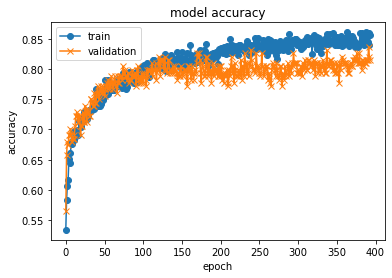

In [17]:
# Plotagem da acurácia de Treinamento e Validação
plt.figure(1)
plt.plot(hist.history['accuracy'], 'o-')
plt.plot(hist.history['val_accuracy'], 'x-')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

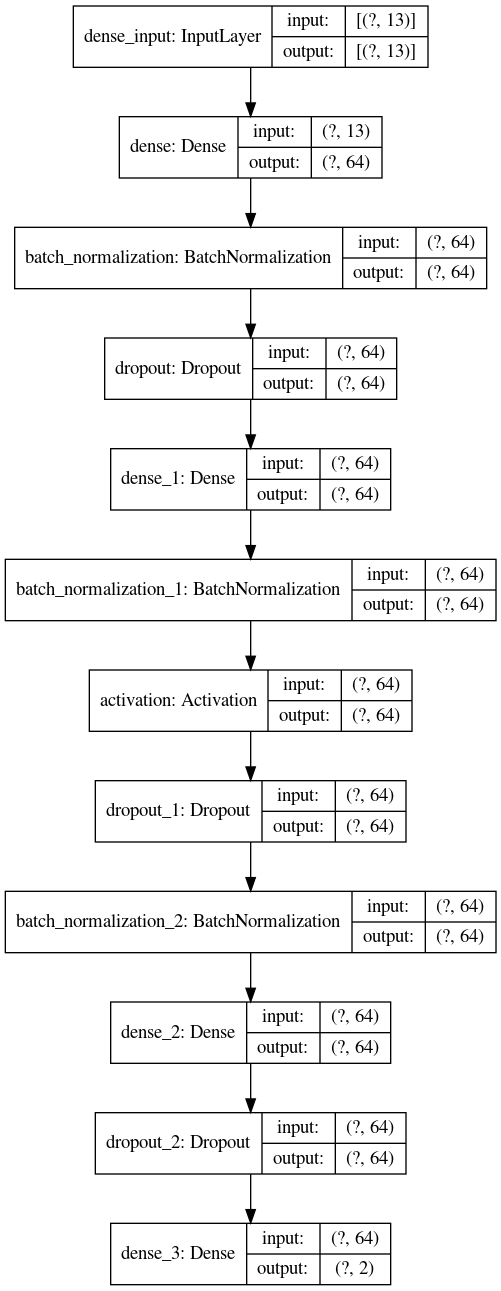

In [18]:
plot_model(model,to_file='5-spotify.png' , show_shapes=True, show_layer_names=True)